<a href="https://colab.research.google.com/github/RomainHerault/PRD/blob/master/Classificateur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Classificateur


##Initialisation

In [0]:
import torch
import numpy as np
import copy
import datetime
import os
import shutil
import cv2
import torch.nn.functional as F
from fluideDataset import fluideDataset
from R2Plus1D import R2Plus1DClassifier
import matplotlib.pyplot as plt


In [3]:
#rootDir = 'D:/Romain/Bureau/automobile-engine-rotation-velocity-master/'
rootDir = 'drive/My Drive/PRD/automobile-engine-rotation-velocity-master/'
testDir = 'drive/My Drive/PRD/'
testDirFullName = 'drive/My Drive/PRD/OneVideo'
seqLength = 15
nbVidPerClass = 2
 
#trainSet = fluideDataset(root = rootDir, seqLength= seqLength, nbVidPerClass=nbVidPerClass, train ='train')
#valSet = fluideDataset(root = rootDir, seqLength= seqLength, nbVidPerClass=nbVidPerClass, train ='val')
testSet = fluideDataset(root = rootDir, seqLength= seqLength, nbVidPerClass=nbVidPerClass, train ='test')
testVideo = fluideDataset(root = testDir, seqLength= seqLength, nbVidPerClass=1, train ='OneVideo')
print("done")



done


In [0]:
!cp -R 500_8_2_Gly_video/ 'drive/My Drive/PRD/500_8_2_Gly_video/'

In [4]:
#trainLoader = torch.utils.data.DataLoader(trainSet,batch_size=6,shuffle = True)
#testLoader = torch.utils.data.DataLoader(testSet,batch_size=1,shuffle = False)
#valLoader = torch.utils.data.DataLoader(valSet,batch_size=1,shuffle = False)

testLoader = torch.utils.data.DataLoader(testVideo,batch_size=1,shuffle = False)

testLen = testSet.__len__() # Nombre d'images dans la base de test
print("nb Images = "+ str(testLen))
#numClasses = trainSet.getNbClass()
numClasses = testSet.getNbClass()
print("nb class = "+ str(numClasses))
model = R2Plus1DClassifier(numClasses, (2, 2, 2, 2), pretrained=False).cuda()

if (os.path.exists('drive/My Drive/PRD/bestModelWts_LocMax060219.pt')):
  print('Pretrained Model existed')
  bestModelWts = torch.load('drive/My Drive/PRD/bestModelWts_LocMax060219.pt')
  #print(bestModelWts)
  model.load_state_dict(bestModelWts)
else:
  print("Le modèle n'est pas entraîné")
  bestModelWts = copy.deepcopy(model.state_dict()) # Copier les paramètres initiaux du modèle 
  

nb Images = 364
nb class = 9
Pretrained Model existed


## Entrainement

In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.01, lr_decay=0.1)
 
nbEpochs = 30 # Nombre d'époch
trainLen = trainSet.__len__() # Nombre d'images dans la base d'entrainement
testLen = testSet.__len__() # Nombre d'images dans la base de test
validationLen = valSet.__len__() # Nombre d'images dans la base de validation
bestAcc = 0.0 # Définition de la précision

for epoch in range(nbEpochs):
    epochLoss = 0.0
    epochAcc = 0.0
    corrects = 0
    i = 0
    # Phase d'entrainement
    for datum in trainLoader:
        inputs,labels = datum[0].cuda(),datum[1].cuda()
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        epochLoss += loss.item()
        if i%50 == 49:
            print('At epoch %d, the mean loss after %d batch data is : %.3f' %(epoch+1,i+1,epochLoss/(2*(i+1))))
        i = i+1
    print('Epoch %d loss for training: %.3f' %(epoch+1,epochLoss/trainLen))
    del outputs
    # Phase de validation
    for datum in valLoader:
        inputs, labels = datum[0].cuda(), datum[1].cuda()
        outputs = model(inputs.float())
        _,preds = torch.max(outputs.data,1)
        corrects += torch.sum(preds == labels.data)
    epochAcc = 1.0*corrects.tolist()/validationLen
    print('Epoch %d accuracy for validation: %.3f' %(epoch+1,epochAcc))
    del outputs
    # Choisir les meilleurs paramètres pour le modèle 
    if epochAcc>bestAcc:
        bestAcc=epochAcc
        bestModelWts = copy.deepcopy(model.state_dict())
        torch.save(bestModelWts,'/Model/bestModelWts_'+str((datetime.datetime.now()).day)+'_'+str((datetime.datetime.now()).month)+'.pt')
        
    if (epochLoss/trainLen)<0.05:
        optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)
      
    print('--------------------------------------------------')
      
print('Finish training!')
print('Best validation accuracy: {:4f}'.format(bestAcc))

##Test

In [0]:
# Tester le modèle
corrects = 0.0
testAcc = 0.0
pred = np.empty(0,dtype=np.int)
groundTruth = np.empty(0,dtype = np.int)
i = 0

for datum in testLoader:
    print(i)
    inputs,labels = datum[0].cuda(),datum[1].cuda()
    #print("inputs :")
    #print(inputs)
    print("labels :")
    print(labels)
    outputs = model(inputs.float())
    _,preds = torch.max(outputs,1)
    corrects += torch.sum(preds == labels.data)
    print(corrects)
    pred = np.concatenate((pred,preds.cpu().numpy()))
    groundTruth = np.concatenate((groundTruth,labels.cpu().numpy()))
    print(preds)
    print(pred)
    print(labels.cpu().numpy())
    print(groundTruth)

    i += 1
testAcc = corrects.tolist()/testLen

print('Test accuracy is: {:3f}'.format(testAcc))

0
labels :
tensor([0], device='cuda:0')
tensor(1., device='cuda:0')
tensor([0], device='cuda:0')
[0]
[0]
[0]
1
labels :
tensor([0], device='cuda:0')
tensor(2., device='cuda:0')
tensor([0], device='cuda:0')
[0 0]
[0]
[0 0]


KeyboardInterrupt: ignored

# LIME


In [5]:
def batch_predict(clip):
  outputs = model(clip.cuda().float())
  #_,probs = torch.max(outputs,1)
  probs = F.softmax(outputs, dim=1)

  #  print(probs.detach().cpu().numpy())
  return probs.detach().cpu().numpy()
print("done")

done


In [0]:
#dataiter = iter(testLoader)
#clip, labels = dataiter.next()

i = 0
for datum in testLoader:
  print(i)
  clip, labels = datum[0].cuda(),datum[1].cuda()
  print(batch_predict(clip))
  break;
  i+=1;

#Segmentation

##Traitement sur les inputs

Création d'un dossier temporaire regroupant toutes les images de notre vidéo, de manière à pouvoir faire une meilleure segmentation.


In [0]:
numImages = 0
for path in ([f.path for f in os.scandir(testDirFullName) if f.is_dir()]):
  tempVideoFolder = os.path.basename(path)+"_video"
  if not os.path.isdir(tempVideoFolder):
    os.mkdir(tempVideoFolder)
  for filepath in ([f.path for f in os.scandir(path) if f.is_dir()]):
    numFolder = int(os.path.basename(filepath))
    for filename in os.listdir(filepath):
      base, extension = os.path.splitext(filename)
      num_file = numFolder * 30 + int(base)
      if(numImages<num_file):
        numImages = num_file
      new_name =  os.path.join(tempVideoFolder,  str(num_file)+extension)
      shutil.copy(os.path.join(filepath,filename), new_name)
print("done !")
    
    

done !


Conversion de la vidéo en clip et classification

In [0]:
scaleFactor = [1,np.sqrt(2),2, 2*np.sqrt(2),4]
def calcDoG(image):
        dogImg = np.empty((image.shape[0],image.shape[1],0))
        dog1 = -cv2.GaussianBlur(image,(0,0),scaleFactor[0])+image
        dog1[dog1<0]=0
        dog1 = np.expand_dims(dog1,axis = 2)
        dogImg = dogImg = np.concatenate((dogImg,dog1),axis = 2)
        for k in range(len(scaleFactor)-1):
            blur1 = cv2.GaussianBlur(image,(0,0),scaleFactor[k])
            blur2 = cv2.GaussianBlur(image,(0,0),scaleFactor[k+1])
            tempDoG = blur1 - blur2 
            tempDoG[tempDoG<0]=0
            tempDoG = np.expand_dims(tempDoG,axis = 2)
            dogImg = np.concatenate((dogImg,tempDoG),axis = 2)
        return dogImg

def convertFolderToClip(videoFolder, seqLength):
  """
  Convert the png files to a clip
  videoFolder : the folder that contains all the png files
  seqLength : the number of images we want to take to create the clip 
  (the function takes the first n images)
  """
  filenames = []
  for filename in os.listdir(videoFolder):
    base, extension = os.path.splitext(filename)
    filenames.append(int(base))
  filenames.sort()
  clip = np.empty((0,96,256,5))
  for img_num in filenames :
    image = cv2.imread(videoFolder+"/"+str(img_num)+extension,0).astype(np.float64)/255.0
    image = cv2.resize(image, (256,96),interpolation=cv2.INTER_AREA)
    dogImg = calcDoG(image)
    dogImg = np.expand_dims(dogImg,axis = 0)
    clip = np.concatenate((clip,dogImg),axis = 0)
    if(img_num == seqLength):
      break
  clip = torch.from_numpy(np.array(clip.transpose([3,0,1,2])))
  print(clip.shape)
  return clip.unsqueeze(0)

#print(batch_predict(convertFolderToClip(tempVideoFolder,15)))

def convertImagesToClip(images_list):
  """
  Convert the images files to a clip
  videoFolder : the folder that contains all the png files
  seqLength : the number of images we want to take to create the clip 
  (the function takes the first n images)
  """
  clip = np.empty((0,96,256,5))
  for image in images_list :
    image =  image.astype(np.float64)/255.0
    image = cv2.resize(image, (256,96),interpolation=cv2.INTER_AREA)
    dogImg = calcDoG(image)
    dogImg = np.expand_dims(dogImg,axis = 0)
    clip = np.concatenate((clip,dogImg),axis = 0)
  clip = torch.from_numpy(np.array(clip.transpose([3,0,1,2])))
  return clip.unsqueeze(0)

#print(batch_predict(convertImagesToClip(images_list)))


##Installation 
Exécuter la première fois

In [0]:
%%shell
apt-get install build-essential cmake libboost-all-dev
git clone https://github.com/davidstutz/hierarchical-graph-based-video-segmentation.git
cd hierarchical-graph-based-video-segmentation
mkdir build
cd build
cmake ..
make


Segmentation des images du dossier temporaire

In [0]:
  tempFlowFolder = os.path.basename(tempVideoFolder)+"_flow"
  if not os.path.isdir(tempFlowFolder):
    os.mkdir(tempFlowFolder)
  tempOutFolder = os.path.basename(tempVideoFolder)+"_out"
  if not os.path.isdir(tempOutFolder):
    os.mkdir(tempOutFolder)
  tempVisFolder = os.path.basename(tempVideoFolder)+"_vis"
  if not os.path.isdir(tempVisFolder) :
    os.mkdir(tempVisFolder)
  print("Path = "+tempVideoFolder)
  print("FlowFolder = "+ tempFlowFolder)
  !./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --input-dir '$tempVideoFolder' --output-dir $tempFlowFolder
  !rm /content/$tempVideoFolder/0.png
  !./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli '$tempVideoFolder' $tempFlowFolder --length $numImages --hierarchies 50 --vis-dir $tempVisFolder --output-dir tempOutFolder --input-gt ""
  """
  for filename in os.listdir(tempVideoFolder):
    print(filename)
  """


In [0]:
!pwd

/content


In [0]:
%cd /content/

/content


##Traitement sur les segments
Conversion des images de segmentations en objets segments

In [6]:
visualisation_folder = 'drive/My Drive/PRD/500_8_2_Gly_video_vis/40it-30frames'

#print(im.shape)
dico = dict()
current_label = 0

segments_list = []#liste des segments de chaque image

#un segment = tableau de la taille de l'image contenant
#le label du segmentu pour chaque pixel

#Pour chaque image du dossier
for f in os.listdir(visualisation_folder) :
  im = cv2.imread(visualisation_folder+"/"+f)
  #On créé un segment en labélisant les couleurs de l'image
  segment = np.zeros((im.shape[0], im.shape[1]))
  for x in range(im.shape[0]):
    for y in range(im.shape[1]):
      couleur = tuple(im[x,y])
      if (couleur not in dico):
        current_label += 1
        dico[couleur] = current_label
      segment[x,y] = dico[couleur]
  segments_list.append(segment)
print(len(segments_list))

nb_segments = current_label

30


##Ancienne version

In [0]:
for path in ([f.path for f in os.scandir(testDirFullName) if f.is_dir()]):
  tempFlowFolder = os.path.basename(path)+"_flow"
  if not os.path.isdir(tempFlowFolder):
    os.mkdir(tempFlowFolder)
  tempOutFolder = os.path.basename(path)+"_out"
  if not os.path.isdir(tempOutFolder):
    os.mkdir(tempOutFolder)
  tempVisFolder = os.path.basename(path)+"_vis"
  if not os.path.isdir(tempVisFolder) :
    os.mkdir(tempVisFolder)
  print("Path = "+path)
  print("FlowFolder = "+ tempFlowFolder)
  for filepath in ([f.path for f in os.scandir(path) if f.is_dir()]):
    tempFlowSubFolder = tempFlowFolder + '/' + os.path.basename(filepath)
    tempOutSubFolder = tempOutFolder + '/' + os.path.basename(filepath)
    tempVisSubFolder = tempVisFolder + '/' + os.path.basename(filepath)
    print("SubFolder = "+tempFlowSubFolder)
    print(filepath)
    !./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --input-dir '$filepath' --output-dir $tempFlowSubFolder
    !./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli '$filepath' $tempFlowSubFolder --length 29 --hierarchies 20 --vis-dir $tempVisSubFolder --output-dir tempOutSubFolder --input-gt ""

In [0]:
!./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --input-dir 'drive/My Drive/PRD/OneVideo/500_8_2_Gly/1' --output-dir output-flow

In [0]:
!./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli 'drive/My Drive/PRD/OneVideo/500_8_2_Gly/0' output-flow/ --length 29 --hierarchies 20 --vis-dir output-vis --output-dir output --input-gt ""

segment_cli: /content/hierarchical-graph-based-video-segmentation/segment_cli/main.cpp:161: int main(int, char**): Assertion `video.getFrameNumber() == flowVideo.getFrameNumber()' failed.


###Test

In [0]:
!./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --input-dir 'Test Segment' --output-dir output-flow

In [0]:
!./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli 'Test Segment2' output-flow/ --hierarchies 20 --vis-dir output-vis --output-dir output --input-gt ""

In [0]:
!./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --help

In [0]:
!./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli --help

In [0]:
%cd hierarchical-graph-based-video-segmentation/build/

In [0]:

!./optical_flow_cli/optical_flow_cli --input-dir ../alley_1 --output-dir output-flowtest

In [0]:
!./segment_cli/segment_cli ../alley_1 ../alley_1_flow/ --vis-dir output_vis --input-gt ../alley_1_gt/

In [0]:
! rm /content/$tempFlowFolder/*

rm: cannot remove '/content/500_8_2_Gly_video_flow/*': No such file or directory


#Explainer

In [7]:
!pip install lime


     |████████████████████████████████| 276kB 12.4MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=f7e897a9b27c54ed7e328c5fadcfce55739edebef4f2549642aa611530391327
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=19790fd5f8381dd21d4302aeaa506cd5493bc0bf697f454986b0fab1352343cd
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

##LimeVideo

###Creation des images via les fichiers

In [0]:
#Importation des images : 
images_folder = 'drive/My Drive/PRD/30frames'

images_list = []#liste des segments de chaque image

#Pour chaque image du dossier
for f in os.listdir(images_folder) :
  im = cv2.imread(images_folder+"/"+f,0)
  images_list.append(im)

###LimeVideoExplainer

In [0]:
"""
Functions for explaining classifiers that use Image data.
"""
import copy
from functools import partial

import numpy as np
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from skimage.color import gray2rgb, rgb2gray
from progressbar import ProgressBar
from lime import lime_base
from google.colab.patches import cv2_imshow



class VideoExplanation(object):
    def __init__(self, images, segments):
        """Init function.

        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        self.images = images
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = None

    def get_images_and_masks(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        images = self.images
        exp = self.local_exp[label]
        temps = []
        masks = []
        for i in range(len(images)):
          image = images[i]
          segment = segments[i]
          mask = np.zeros(segment.shape, dtype=int)
          if hide_rest:
              temp = np.zeros(image.shape)
          else:
              temp = image.copy()
          if positive_only:
              fs = [x[0] for x in exp
                    if x[1] > 0 and x[1] > min_weight][:num_features]
          if negative_only:
              fs = [x[0] for x in exp
                    if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
          if positive_only or negative_only:
              for f in fs:
                  temp[segment == f] = image[segment == f].copy()
                  mask[segment == f] = 1
              temps.append(temp)
              masks.append(mask)
          else:
              for f, w in exp[:num_features]:
                  if np.abs(w) < min_weight:
                      continue
                  c = 0 if w < 0 else 1
                  mask[segment == f] = -1 if w < 0 else 1
                  temp[segment == f] = image[segment == f].copy()
                  temp[segment == f, c] = np.max(image)
              temps.append(temp)
              masks.append(mask)
        return temps, masks


class LimeVideoExplainer(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.
        
        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
              width as input and outputs weights in (0,1). If None, defaults to
              an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
              'forward_selection', 'lasso_path', 'none' or 'auto'.
              See function 'explain_instance_with_data' in lime_base.py for
              details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
              generate random numbers. If None, the random state will be
              initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)
        
        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
        
        kernel_fn = partial(kernel, kernel_width=kernel_width)
        
        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = lime_base.LimeBase(kernel_fn, verbose, random_state=self.random_state)

    def explain_instance(self, images_list, classifier_fn, labels=(1,),
                        hide_color=None,
                        top_labels=5, num_features=100000, num_samples=1000,
                        batch_size=10,
                        segments=None,
                        distance_metric='cosine',
                        model_regressor=None,
                        random_seed=None):
        """Generates explanations for a prediction.
        
        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).
        
        Args:
          image: 3 dimension RGB image. If this is only two dimensional,
              we will assume it's a grayscale image and call gray2rgb.
          classifier_fn: classifier prediction probability function, which
              takes a numpy array and outputs prediction probabilities.  For
              ScikitClassifiers , this is classifier.predict_proba.
          labels: iterable with labels to be explained.
          hide_color: TODO
          top_labels: if not None, ignore labels and produce explanations for
              the K labels with highest prediction probabilities, where K is
              this parameter.
          num_features: maximum number of features present in explanation
          num_samples: size of the neighborhood to learn the linear model
          batch_size: TODO
          distance_metric: the distance metric to use for weights.
          model_regressor: sklearn regressor to use in explanation. Defaults
          to Ridge regression in LimeBase. Must have model_regressor.coef_
          and 'sample_weight' as a parameter to model_regressor.fit()
          segmentation_fn: SegmentationAlgorithm, wrapped skimage
          segmentation function
          random_seed: integer used as random seed for the segmentation
              algorithm. If None, a random integer, between 0 and 1000,
              will be generated using the internal random number generator.
        
        Returns:
          An ImageExplanation object (see lime_image.py) with the corresponding
          explanations.
        """
        images = []
        for image in images_list:
            if len(image.shape) == 2:
                images.append(gray2rgb(image))
            else:
                images.append(image)
        
        images = np.array(images)
        
        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)
        
        """
        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                  max_dist=200, ratio=0.2,
                                                  random_seed=random_seed)
        try:
            segments = segmentation_fn(image)
        except ValueError as e:
            raise e
        """
        fudged_image_list = []
        for image in images :
            fudged_image = image.copy()
            if hide_color is None:
                for x in np.unique(segments):#TODO
                    fudged_image[segments == x] = (
                        np.mean(image[segments == x][:, 0]),
                        np.mean(image[segments == x][:, 1]),
                        np.mean(image[segments == x][:, 2]))
            else:
                fudged_image[:] = hide_color
            fudged_image_list.append(fudged_image)
        
        top = labels
        data, labels = self.data_labels(images, fudged_image_list, segments,
                                      classifier_fn, num_samples,
                                      batch_size=batch_size)
        
        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()
        
        
        ret_exp = VideoExplanation(images, segments)
        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        for label in top:
            (ret_exp.intercept[label],
                ret_exp.local_exp[label],
                ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp
        
        #return data, labels

    def data_labels(self,
                    images,
                    fudged_images,
                    segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10):
        """Generates images and predictions in the neighborhood of this image.

        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.

        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        #n_features = np.unique(segments).shape[0]
        n_features = nb_segments

        data = self.random_state.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features))
        labels = []
        data[0, :] = 1
        neighboorhood = []
        pbar = ProgressBar(num_samples)
        pbar.start()
        for row in data:
            temp_img_list = copy.deepcopy(images)
            zeros = np.where(row == 0)[0]
            temp_2d_img_list = []
            for i in range(len(images)):
                mask = np.zeros(segments[i].shape).astype(bool)
                for z in zeros:
                    mask[segments[i] == z] = True
                temp_img_list[i][mask] = fudged_images[i][mask]
                temp_2d_img_list.append(rgb2gray(temp_img_list[i]))
            neighboorhood.append(temp_2d_img_list)
            if len(neighboorhood) == batch_size:
                for neighboor in neighboorhood:
                    preds = classifier_fn(convertImagesToClip(neighboor))
                    labels.extend(preds)
                neighboorhood = []
            pbar.currval += 1
            pbar.update()
        pbar.finish()
        if len(neighboorhood) > 0:
            for neighboor in neighboorhood:
                preds = classifier_fn(convertImagesToClip(neighboor))
                labels.extend(preds)
        return data, np.array(labels)

###Lancement de Lime

30


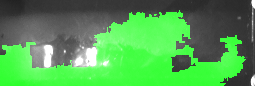

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


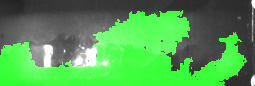

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


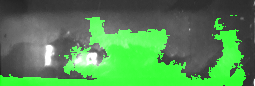

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


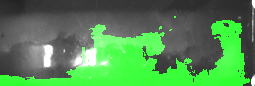

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


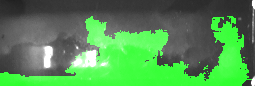

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


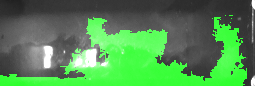

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


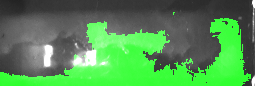

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


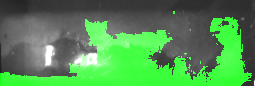

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


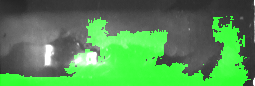

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


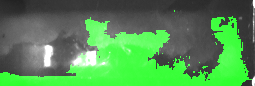

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


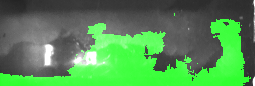

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


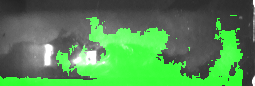

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


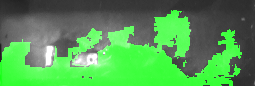

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


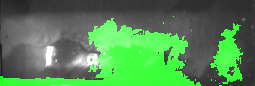

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


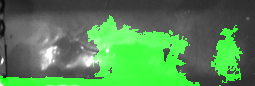

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


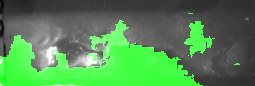

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


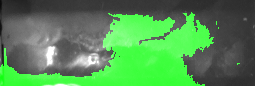

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


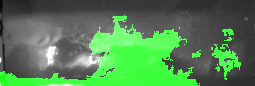

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


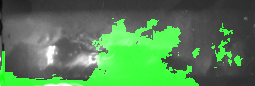

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


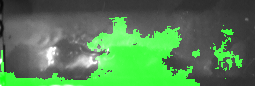

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


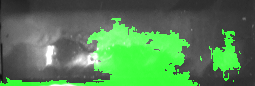

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


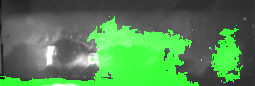

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


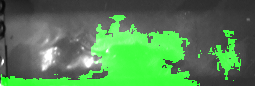

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


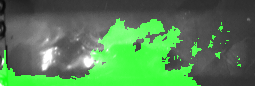

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


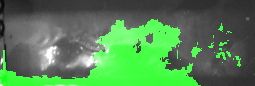

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


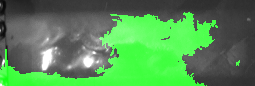

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


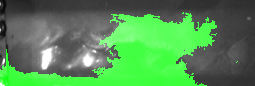

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


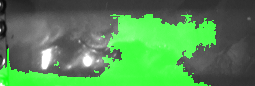

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


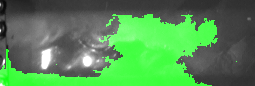

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


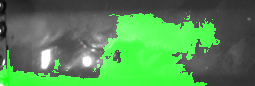

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


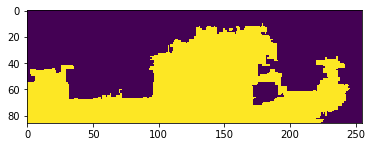

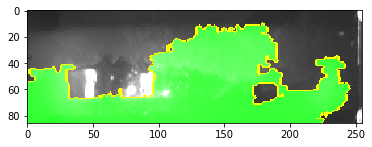

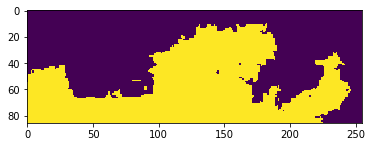

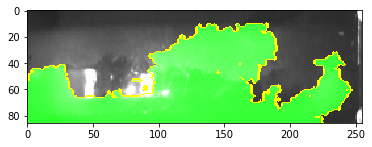

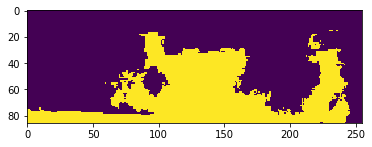

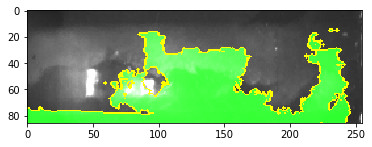

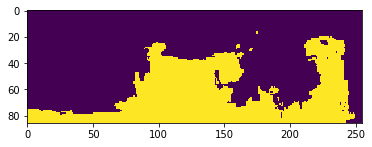

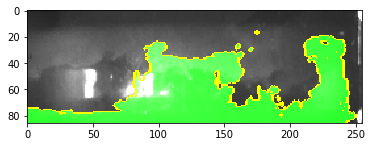

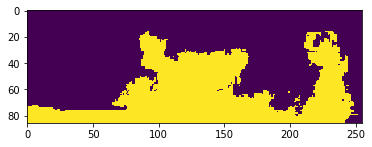

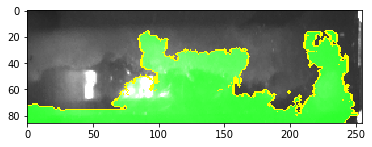

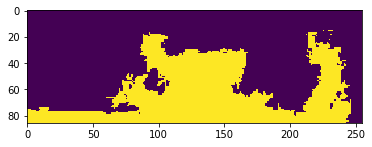

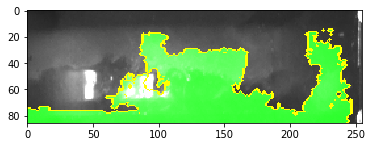

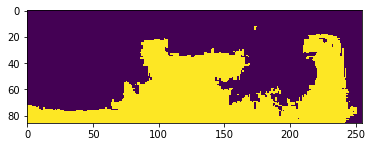

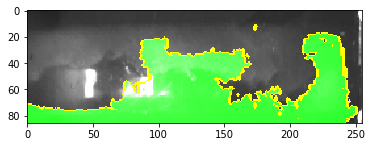

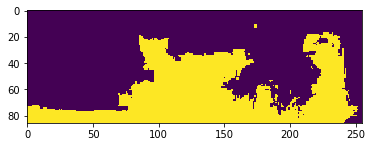

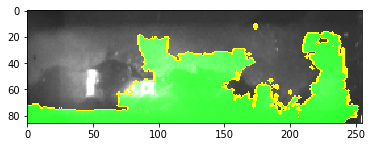

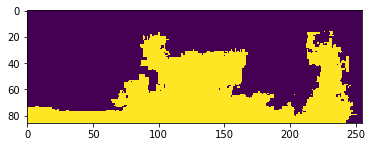

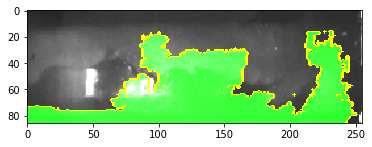

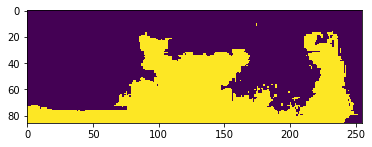

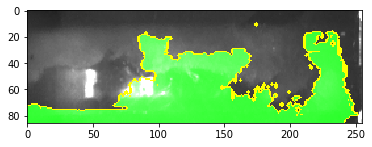

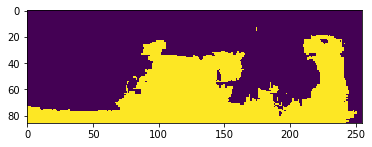

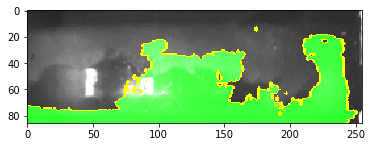

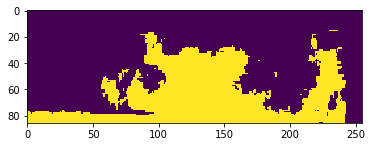

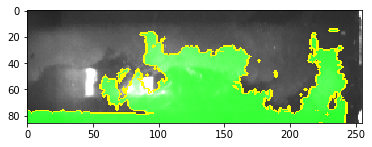

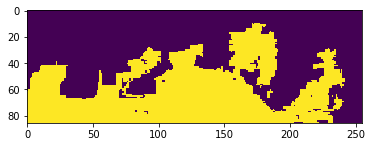

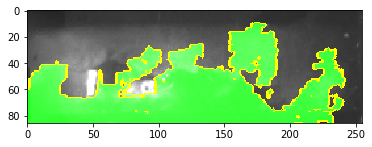

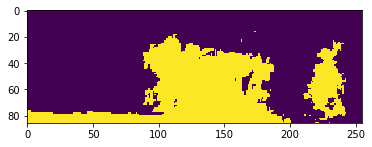

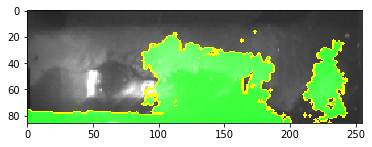

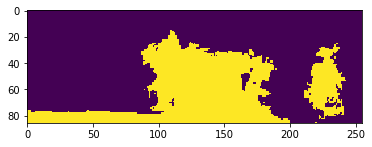

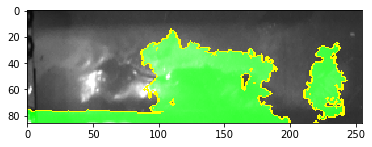

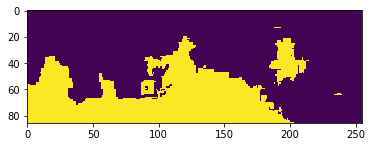

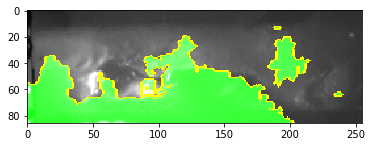

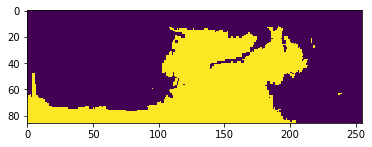

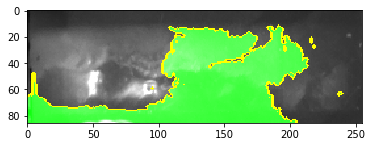

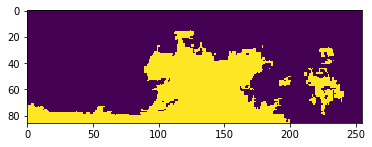

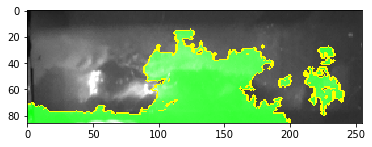

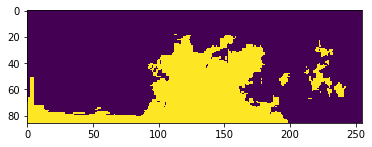

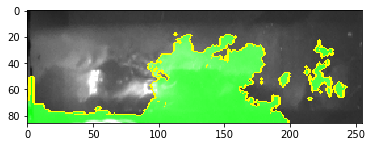

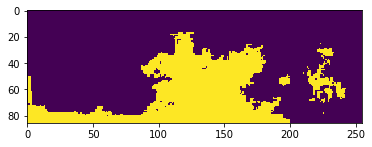

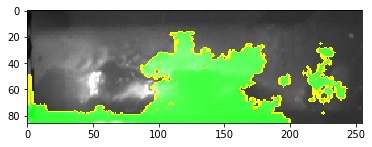

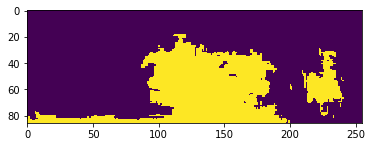

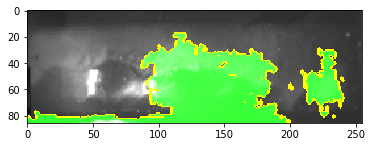

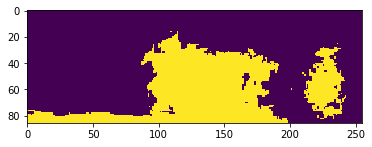

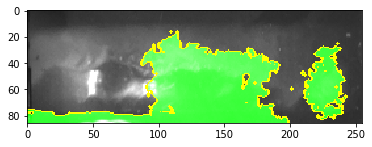

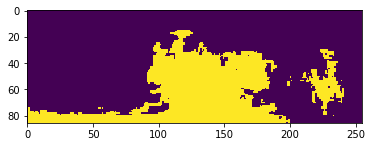

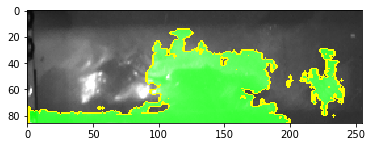

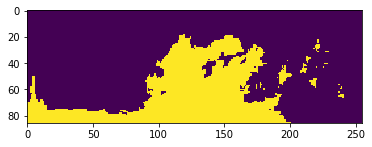

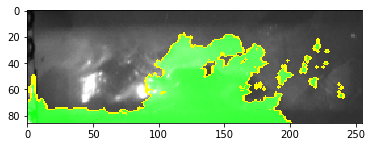

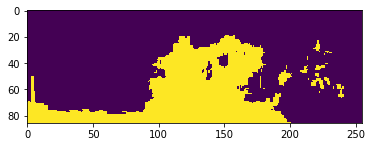

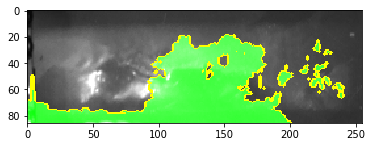

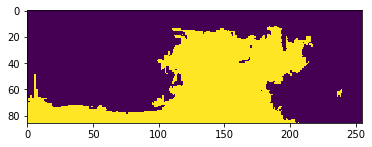

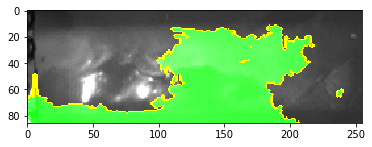

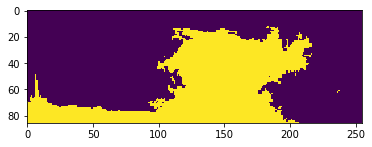

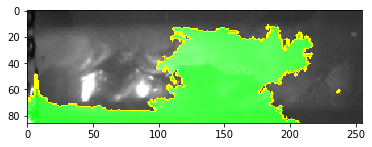

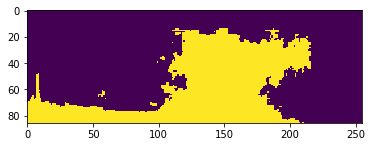

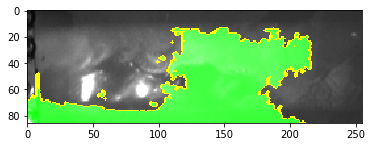

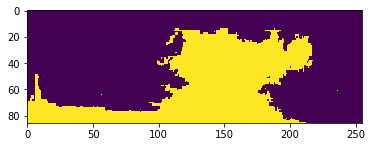

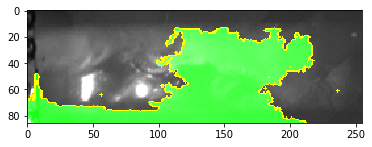

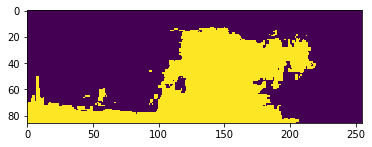

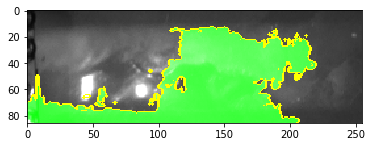

In [27]:
print(len(images_list))
import time
import matplotlib.pyplot as plt

start = time.time()
explainer = LimeVideoExplainer(verbose=False)
#cv2_imshow(images_list[0])
explanation = explainer.explain_instance(np.array(images_list), 
                                         batch_predict, # classification function
                                         batch_size = 10,
                                         top_labels=5, 
                                         hide_color=0,
                                         segments = segments_list,
                                         num_samples=10, # number of images that will be sent to classification function
                                         random_seed=1)

temps, masks = explanation.get_images_and_masks(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
for temp, mask in zip(temps,masks):
  plt.imshow(temp)
  #cv2_imshow(mask)
  plt.figure()
  plt.imshow(mask)
  img_boundry1 = mark_boundaries(temp/255.0, mask)
  plt.figure()
  plt.imshow(img_boundry1)
